<a href="https://colab.research.google.com/github/ashivashankars/Team_4Musketeers_capstone_project/blob/main/ScrapeFeatures.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Extract features from Job's webpage
Apply NLP techniques to extract 'Years of Experience', 'Diploma Type', 'Job Type', 'Sponsorship Requirement', and 'Skill Sets' from the text content in the `/content/all_internships_with_content.csv` file, and then save the augmented data to a new CSV file.
Before proceeding, it's essential to mount Google Drive to access the dataset located at /content/drive/MyDrive/Colab Notebooks/all_internships_with_content.csv.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Load Data

### Loading Data and Initial Inspection

Load the CSV file into a pandas DataFrame, display the first 5 rows, and print a concise summary to inspect its structure, as requested by the subtask instructions.Load the /content/all_internships_with_content.csv file into a pandas DataFrame and inspect its structure.

This cell performs the following actions:
1.  **Imports necessary libraries**: `pandas` for data manipulation, `csv` and `sys` for handling potential CSV field size limits.
2.  **Adjusts CSV field size limit**: Temporarily increases the CSV field size limit to `sys.maxsize` to prevent errors when reading large text fields in the CSV.
3.  **Loads the CSV file**: Reads the `all_internships_with_content.csv` file into a pandas DataFrame. It uses `engine='python'` and `on_bad_lines='skip'` to handle potential formatting issues and `header=None` initially.
4.  **Sets header and cleans DataFrame**: Assumes the first row is the header, sets it as the DataFrame's columns, and then removes the duplicate header row.
5.  **Prints head and info**: Displays the first 5 rows of the DataFrame using `df.head()` and a concise summary using `df.info()` to inspect its structure, data types, and non-null counts.
6.  **Resets CSV field size limit**: Restores the CSV field size limit to its original value in a `finally` block to ensure clean state.

In [2]:
import pandas as pd
import csv
import sys

# Get the current field size limit
current_limit = csv.field_size_limit()

# Set a new, larger field size limit to handle large fields
csv.field_size_limit(sys.maxsize)

try:
    # Try reading the CSV with 'on_bad_lines='skip' to bypass problematic rows
    # Use header=None to prevent the first row from being interpreted as headers
    df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/all_internships_with_content.csv', engine='python', on_bad_lines='skip', header=None)

    # Set the first row as the header and then drop the first row
    df.columns = df.iloc[0]
    df = df[1:].reset_index(drop=True)

    print("First 20 rows of the DataFrame:")
    print(df.head())

    print("\nConcise summary of the DataFrame:")
    df.info()
finally:
    # Reset the field size limit to its original value
    csv.field_size_limit(current_limit)

First 20 rows of the DataFrame:
0                  Company                               Role  \
0  The Walt Disney Company                Data Product Intern   
1                Teamworks          Product Management Intern   
2                  Zscaler     Product Management Intern - AI   
3              🔥ServiceNow         Portfolio Associate Intern   
4                Santander  Digital Product Management Intern   

0         Location                                        Application Age  \
0  Celebration, FL  https://disney.wd5.myworkdayjobs.com/disneycar...  0d   
1    Remote in USA  https://ats.rippling.com/teamworks-careers/job...  0d   
2     San Jose, CA  https://job-boards.greenhouse.io/zscaler/jobs/...  1d   
3      Chicago, IL  https://jobs.smartrecruiters.com/ServiceNow/74...  1d   
4       Boston, MA  https://santander.wd3.myworkdayjobs.com/Santan...  1d   

0                                           raw_html  \
0  <!DOCTYPE html>\n<html lang="en-US">\n<head>\n...   
1 

# NLP techniques
Develop and apply NLP techniques (e.g., regular expressions) to extract numeric values representing 'Years of Experience' from the text content. The extracted value will be converted to a numeric type.

#### Instructions
1. Fill any missing values in the 'text_content' column with an empty string to ensure regex operations do not fail.
2. Define a regular expression pattern to capture numerical values related to 'years of experience'. Consider variations like 'X years', 'X+ years', 'X-Y years', or 'minimum X years'.
3. Apply the defined regex pattern to the 'text_content' column of the DataFrame `df` to extract potential years of experience.
4. From the extracted matches, determine the most appropriate single numeric value (e.g., the lower bound for ranges like '3-5 years', or the number itself for '3+ years').
5. Convert the extracted numeric values to an integer or float type.
6. Store the extracted and converted 'Years of Experience' in a new column named 'YOE' in the DataFrame `df`. If no experience is found, assign a default value like 0 or NaN.

### Handling Missing Values in 'text_content'

This cell addresses missing values in the crucial 'text_content' column:
1.  **Fills NaN values**: It replaces any `NaN` (Not a Number) entries in the 'text_content' column with an empty string (`''`). This step is vital to ensure that subsequent text processing operations (like regular expression matching) do not fail or raise errors when encountering non-string values.
2.  **Verifies missing values**: After the operation, it prints the sum of null values in the 'text_content' column to confirm that all `NaN`s have been successfully handled and replaced.

In [3]:
df['text_content'] = df['text_content'].fillna('')
print("Missing values in 'text_content' after filling NaNs:")
print(df['text_content'].isnull().sum())

Missing values in 'text_content' after filling NaNs:
0


### Defining and Applying Extract Years of Experience (YOE) Regex Pattern

This cell focuses on defining and applying the regular expression pattern to extract potential 'Years of Experience' from the `text_content`: regular expression pattern to capture various formats of 'years of experience' and apply it to the 'text_content' column. This will involve using re.findall or str.findall to get all potential matches for each entry.

1.  **Imports `re`**: Imports the regular expression module in Python.
2.  **Defines `experience_pattern`**: Creates a compiled regex pattern designed to capture various formats of years of experience, such as 'X years', 'X+ years', 'X-Y years', or 'minimum X years'. The pattern is made case-insensitive by applying `.lower()` to the text before matching.
3.  **Applies pattern to `text_content`**: Uses the `apply` method on the `text_content` column with a lambda function to find all matches of the `experience_pattern` in each entry. The results (a list of tuples for each row containing matched strings) are stored in a new column named `extracted_yoe_matches`.
4.  **Prints head and match count**: Displays the first 5 rows of the `extracted_yoe_matches` column to show examples of extracted matches and prints the total number of rows where at least one experience match was found, providing an overview of the extraction success.

In [20]:
import re

# Define a regex pattern to capture years of experience
# This pattern looks for numbers (X, X+, X-Y) followed by 'year(s)' with optional words in between.
# It also considers 'minimum X years' and similar phrases.
# The regex has been refined to primarily look for 1 or 2-digit numbers for 'years of experience',
# which are more realistic for job requirements, to reduce false positives from larger numbers.
experience_pattern = re.compile(r'(\b\d{1,2}\+?|\b\d{1,2}\s*(?:to|-)\s*\d{1,2}|\b\d{1,2})\s*(?:years?|yrs?|yr)\s*(?:of\s*experience|experience)?|minimum\s*(\b\d{1,2})\s*(?:years?|yrs?|yr)')

# Apply the pattern to the 'text_content' column to find all matches
df['extracted_yoe_matches'] = df['text_content'].apply(lambda x: experience_pattern.findall(x.lower()))

print("First 5 rows of 'extracted_yoe_matches' column:")
print(df['extracted_yoe_matches'].head())

print("\nNumber of rows with extracted experience matches:")
print(df[df['extracted_yoe_matches'].apply(lambda x: len(x) > 0)].shape[0])

First 5 rows of 'extracted_yoe_matches' column:
0          []
1    [(3+, )]
2          []
3          []
4          []
Name: extracted_yoe_matches, dtype: object

Number of rows with extracted experience matches:
134


### Parsing and Standardizing Years of Experience (YOE)

This cell processes the raw regex matches to derive a single, standardized numeric value for 'Years of Experience':
1.  **Defines `parse_yoe` function**: This function takes a list of regex matches (tuples) as input and processes them to extract numeric years. It handles:
    *   **Ranges**: For patterns like '3-5 years' or '3 to 5 years', it extracts the lower bound (e.g., 3).
    *   **'X+ years'**: Extracts the numeric part (e.g., 3 from '3+ years').
    *   **Simple numbers**: Converts direct numeric matches to integers.
    *   It collects all valid numeric years and returns the minimum value found, reflecting the common 'at least X years' requirement. If no valid YOE is found, it returns `None`.
2.  **Applies `parse_yoe`**: The function is applied to the `extracted_yoe_matches` column, and the results are stored in a new column named `YOE`.
3.  **Fills `None` values**: Any remaining `None` values in the `YOE` column (where no experience was found) are filled with `0`.
4.  **Prints head and value counts**: Displays the first 5 rows of the `YOE` column and the value counts for non-zero YOE entries, offering a summary of the extracted experience distribution.

In [21]:
def parse_yoe(matches):
    yoe_values = []
    for match_tuple in matches:
        # The regex has two main capturing groups: one for standard patterns and one for 'minimum X years'
        # We need to check both parts of the tuple
        for match_str in match_tuple:
            if match_str:
                # Handle ranges like '3-5 years' or '3 to 5 years'
                if 'to' in match_str or '-' in match_str:
                    parts = re.findall(r'\d+', match_str)
                    if parts: # Take the lower bound of the range
                        yoe_values.append(int(parts[0]))
                # Handle 'X+ years'
                elif '+' in match_str:
                    yoe_values.append(int(match_str.replace('+', '')))
                # Handle simple 'X years' or 'minimum X years'
                else:
                    try:
                        yoe_values.append(int(match_str))
                    except ValueError:
                        pass # Ignore non-numeric strings that might slip through

    # Filter out unreasonable YOE values (e.g., > 50 years is highly unlikely for job requirements)
    filtered_yoe_values = [y for y in yoe_values if 0 <= y <= 50]

    if filtered_yoe_values:
        # Return the minimum years of experience found, as typically a requirement is 'at least X years'
        return min(filtered_yoe_values)
    return None # Return None if no valid YOE found

df['YOE'] = df['extracted_yoe_matches'].apply(parse_yoe)

# Fill any remaining None values with a default (e.g., 0 or NaN)
# Using NaN to distinguish between 'no experience found' and '0 years experience'
df['YOE'] = df['YOE'].fillna(0) # Default to 0 if nothing is found, as per instruction to assign 0 or NaN

print("First 5 rows of 'YOE' column:")
print(df['YOE'].head())

print("\nValue counts for 'YOE' column (showing non-zero values):")
print(df[df['YOE'] > 0]['YOE'].value_counts().sort_index())

First 5 rows of 'YOE' column:
0    0.0
1    3.0
2    0.0
3    0.0
4    0.0
Name: YOE, dtype: float64

Value counts for 'YOE' column (showing non-zero values):
YOE
1.0     36
2.0     20
3.0     12
5.0      1
6.0      4
8.0      1
10.0     3
15.0     1
16.0     1
18.0    25
25.0     1
28.0     2
30.0     2
35.0     1
40.0     6
50.0     1
Name: count, dtype: int64


## Extract Diploma Type
Implement NLP logic to identify and categorize educational diplomas (e.g., 'None', 'Bachelor', 'Master', 'PhD') from the text. The extraction will map to the specified enum values.


#### Instructions Breakdown for Diploma Type Extraction

To effectively extract and categorize diploma types, I will follow these steps:

1.  **Define Diploma Types and Priority**: A dictionary will be created to store standardized diploma names (e.g., 'PhD', 'Master', 'Bachelor', 'Associate', 'High School', 'None') and their corresponding regular expression patterns. The order of keys in this dictionary will reflect the priority for extraction, from highest to lowest educational attainment.

2.  **Regular Expression Patterns**: For each diploma type, I will craft robust regular expression patterns that account for common abbreviations, full names, and variations (e.g., 'PhD', 'doctorate', 'master's degree', 'MS', 'bachelor', 'BS', 'high school diploma'). These patterns will be case-insensitive.

3.  **Iterative Application**: A function will be defined to iterate through the text content. It will attempt to match diploma patterns in the predefined priority order. The first match found will determine the 'Diploma Type' for that entry.

4.  **Assign to 'Diploma' Column**: The extracted diploma type will be stored in a new column named 'Diploma' in the DataFrame `df`.

5.  **Handle Missing Values**: If no diploma type is identified after checking all patterns, 'None' will be assigned to the 'Diploma' column to indicate no specific educational qualification was found or required.

6.  **Verify Extraction**: Finally, the value counts of the newly created 'Diploma' column will be printed to provide an overview of the distribution of extracted educational qualifications.

### Defining Diploma Type Regex Patterns

This cell initializes a dictionary of regular expression patterns for various diploma types:define the prioritized diploma types and their corresponding regular expression patterns in a dictionary. This will serve as the core logic for identifying educational qualifications within the text content.

1.  **Imports `re`**: Ensures the regular expression module is available.
2.  **Defines `diploma_patterns`**: Creates a dictionary where keys are standardized diploma types (e.g., 'PhD', 'Master', 'Bachelor') and values are lists of regex patterns. These patterns cover common abbreviations, full names, and variations for each diploma, designed for case-insensitive matching. The order of keys in the dictionary implicitly defines a priority for extraction, from highest to lowest educational attainment, as specified in the subtask instructions.

In [6]:
import re

# Define diploma types and their regex patterns in order of priority (highest to lowest education)
diploma_patterns = {
    'PhD': [
        r'ph\.d\b',
        r'doctorate\b',
        r'doctoral\s*degree\b',
        r'doctor\s*of\s*philosophy\b'
    ],
    'Master': [
        r'master\.?\s*degree\b',
        r'm\.s\b',
        r'm\.a\b',
        r'mba\b',
        r'msc\b',
        r'graduate\s*degree\b'
    ],
    'Bachelor': [
        r'bachelor\.?\s*degree\b',
        r'b\.s\b',
        r'b\.a\b',
        r'bsc\b',
        r'undergraduate\s*degree\b'
    ],
    'Associate': [
        r'associate\.?\s*degree\b',
        r'a\.a\b',
        r'a\.s\b'
    ],
    'High School': [
        r'high\s*school\s*diploma\b',
        r'high\s*school\s*graduate\b',
        r'ged\b'
    ]
}

print("Diploma patterns defined successfully.")

Diploma patterns defined successfully.


### Extracting and Categorizing Diploma Types

This cell implements the logic to extract and categorize educational diploma types from the `text_content`: Following the defined diploma_patterns, create a function to apply these patterns to the text_content column. This function will iterate through the patterns in order of priority, assign the first found diploma type to a new 'Diploma' column, and default to 'None' if no match is found, then print the value counts.


1.  **Defines `extract_diploma` function**: This function takes a text string, converts it to lowercase, and then iterates through the `diploma_patterns` dictionary in a predefined priority order. For each diploma type, it checks if any of its associated regex patterns are present in the text.
2.  **Returns first match**: As soon as a match is found for a diploma type, that type is returned, ensuring that higher-priority (more advanced) diplomas are captured first.
3.  **Handles no match**: If no diploma pattern is matched after checking all categories, the function returns `'None'`.
4.  **Applies function to DataFrame**: The `extract_diploma` function is applied to the `text_content` column, and the results are stored in a new column named `Diploma`.
5.  **Prints value counts**: Finally, it displays the value counts for the `Diploma` column, showing the distribution of identified educational qualifications across the dataset.

In [7]:
def extract_diploma(text):
    text = str(text).lower() # Ensure text is string and lowercased for case-insensitive matching
    for diploma_type, patterns in diploma_patterns.items():
        for pattern in patterns:
            if re.search(pattern, text):
                return diploma_type
    return 'None'

df['Diploma'] = df['text_content'].apply(extract_diploma)

print("Value counts for 'Diploma' column:")
print(df['Diploma'].value_counts())

Value counts for 'Diploma' column:
Diploma
None           1294
High School     198
Master           51
PhD              31
Bachelor          8
Name: count, dtype: int64


## Extract Job Type

Use NLP to determine the job type (e.g., 'Intern', 'Full-Time', 'Both') from relevant text fields in the dataset. This will involve keyword matching and contextual analysis.

To begin extracting 'Job Type', the first step is to define a comprehensive set of regular expression patterns for each target job type: 'Intern', 'Full-Time', 'Part-Time', and 'Contract'. These patterns will account for variations in wording and abbreviations. This setup is crucial for the subsequent NLP logic, allowing for accurate and prioritized identification of job types within the text content.

Now, I will define the `job_type_patterns` dictionary with regex patterns for 'Intern', 'Full-Time', 'Part-Time', and 'Contract' job types, prioritizing 'Intern' and 'Full-Time' for more common scenarios as per the instructions.


### Defining Job Type Regex Patterns

This cell sets up the regular expression patterns for identifying different job types:
1.  **Imports `re`**: Ensures the regular expression module is available.
2.  **Defines `job_type_patterns`**: Creates a dictionary where keys are specific job types ('Intern', 'Full-Time', 'Part-Time', 'Contract') and values are lists of regex patterns. These patterns capture common wording and abbreviations for each job type, considering case-insensitive matching. The order of job types in this dictionary implies a processing priority, particularly for 'Intern' which is often a key classification in this dataset.

In [8]:
import re

# Define job types and their regex patterns in order of priority
job_type_patterns = {
    'Intern': [
        r'internship\b',
        r'intern\b',
        r'co-op\b',
        r'coop\b'
    ],
    'Full-Time': [
        r'full-time\b',
        r'full\s*time\b',
        r'f/t\b'
    ],
    'Part-Time': [
        r'part-time\b',
        r'part\s*time\b',
        r'p/t\b'
    ],
    'Contract': [
        r'contract\b',
        r'freelance\b'
    ]
}

print("Job type patterns defined successfully.")

Job type patterns defined successfully.


### Extracting and Categorizing Job Types

This cell applies the defined job type patterns to the `text_content` to classify job postings:Now that the job type patterns are defined, I will create a function to iterate through the `text_content` column, apply these patterns in priority order, and assign the first matching job type to a new 'Job_type' column. If no match is found, it will default to 'None'.


1.  **Defines `extract_job_type` function**: This function takes a text string (assumed to be a job description), converts it to lowercase, and then systematically searches for job type indicators.
    *   **Prioritizes 'Intern'**: It first checks for 'Intern' patterns. If found, 'Intern' is immediately returned, as the dataset is focused on internships.
    *   **Checks other types**: If 'Intern' is not found, it then iterates through other job types ('Full-Time', 'Part-Time', 'Contract') to find matches.
    *   **Handles multiple matches**: If multiple non-intern job types are detected (e.g., 'Full-Time' and 'Part-Time'), it uses a simple prioritization logic, favoring 'Full-Time' or returning 'Both' in specific ambiguous cases.
    *   **Defaults to 'None'**: If no job type indicators are found, it returns `'None'`.
2.  **Applies function to DataFrame**: The `extract_job_type` function is applied to the `text_content` column, and the results are stored in a new column named `Job_type`.
3.  **Prints value counts**: Finally, it displays the value counts for the `Job_type` column, providing an overview of the distribution of identified job classifications.

In [9]:
def extract_job_type(text):
    text = str(text).lower() # Ensure text is string and lowercased for case-insensitive matching
    found_job_types = []

    # Check for 'Intern' first due to its common requirement for internships
    for pattern in job_type_patterns['Intern']:
        if re.search(pattern, text):
            found_job_types.append('Intern')
            # If 'Intern' is found, it's typically the primary job type for this dataset
            return 'Intern'

    # Check for other job types if 'Intern' is not found
    for job_type, patterns in job_type_patterns.items():
        if job_type == 'Intern': # Skip intern as it's already checked and returned if found
            continue
        for pattern in patterns:
            if re.search(pattern, text):
                found_job_types.append(job_type)

    if len(found_job_types) > 1:
        # If multiple non-intern job types are found, and no intern was found,
        # we need to decide what to return. For simplicity, we can prioritize or return 'Both'.
        # As the instruction is 'Both' or the most appropriate primary, let's return 'Both'
        # if more than one distinct type is detected (excluding 'Intern' as it's handled).
        # A more sophisticated logic might be needed here based on domain knowledge.
        # For this subtask, let's consider the first one found or 'Both' if ambiguous.
        if 'Full-Time' in found_job_types and 'Part-Time' in found_job_types:
            return 'Both'
        elif 'Full-Time' in found_job_types: # Prioritize Full-Time over others if present
            return 'Full-Time'
        elif 'Part-Time' in found_job_types:
            return 'Part-Time'
        elif 'Contract' in found_job_types:
            return 'Contract'
    elif len(found_job_types) == 1:
        return found_job_types[0]
    return 'None'

# Apply the function to the 'text_content' column
df['Job_type'] = df['text_content'].apply(extract_job_type)

print("Value counts for 'Job_type' column:")
print(df['Job_type'].value_counts())

Value counts for 'Job_type' column:
Job_type
None         905
Intern       549
Full-Time    106
Contract      21
Both           1
Name: count, dtype: int64


## Extract Sponsorship Requirement

Apply NLP to identify if sponsorship is required (True/False or 1/0) based on keywords and phrases in the text content related to visa sponsorship.

#### Instructions
1. Define a list of regular expression patterns to identify phrases indicating a sponsorship requirement (e.g., 'visa sponsorship', 'sponsorship available', 'require sponsorship', 'work authorization'). These patterns should be case-insensitive.
2. Create a function that iterates through these patterns and checks if any match the 'text_content' for each row. The function should return `True` if any sponsorship-related phrase is found, and `False` otherwise.
3. Apply this function to the 'text_content' column of the DataFrame `df`.
4. Store the boolean result in a new column named 'Require_Sponsorship' in the DataFrame `df`.
5. Print the value counts of the 'Require_Sponsorship' column to show the distribution of sponsorship requirements.


### Defining Sponsorship Requirement Regex Patterns

This cell prepares the regular expression patterns needed to identify visa sponsorship requirements:
1.  **Imports `re`**: Ensures the regular expression module is loaded.
2.  **Defines `sponsorship_patterns`**: Creates a list of regex patterns designed to catch various phrases related to visa sponsorship, work authorization, or residency requirements. These patterns are constructed to be case-insensitive, covering both explicit mentions of 'sponsorship' and related terms that imply such a need (e.g., 'work authorization', 'US citizen').

In [10]:
import re

# Define regex patterns for sponsorship keywords
sponsorship_patterns = [
    r'visa\s*sponsorship',
    r'sponsorship\s*available',
    r'require\s*sponsorship',
    r'work\s*authorization',
    r'eligible\s*to\s*work\s*in\s*the\s*us\s*without\s*sponsorship',
    r'only\s*us\s*citizens\s*or\s*green\s*card\s*holders',
    r'us\s*citizen',
    r'green\s*card\s*holder',
    r'no\s*sponsorship',
    r'not\s*sponsor',
    r'can\s*not\s*sponsor'
]

print("Sponsorship patterns defined successfully.")

Sponsorship patterns defined successfully.


### Checking for Sponsorship Requirements

This cell implements the logic to determine if a job requires sponsorship based on the text content:
1.  **Defines `check_sponsorship` function**: This function processes a given text string (representing job content):
    *   **Prioritizes 'No Sponsorship'**: It first checks for phrases explicitly indicating that sponsorship is *not* provided or that candidates must be authorized to work without sponsorship (e.g., 'no sponsorship', 'not sponsor', 'eligible to work in the US without sponsorship'). If any of these are found, it immediately returns `False`.
    *   **Checks for 'Sponsorship Relevant'**: If no 'no sponsorship' phrases are found, it then checks for patterns indicating that sponsorship *might be required or is available*, or that imply specific work authorization restrictions (e.g., 'visa sponsorship', 'require sponsorship', 'only US citizens or green card holders'). If any of these are found, it returns `True`.
    *   **Defaults to `False`**: If neither explicit 'no sponsorship' nor 'sponsorship relevant' phrases are found, the function defaults to returning `False`.
2.  **Applies function to DataFrame**: The `check_sponsorship` function is applied to the `text_content` column, and the boolean results are stored in a new column named `Require_Sponsorship`.
3.  **Prints value counts**: It then displays the value counts for the `Require_Sponsorship` column, showing the distribution of jobs that indicate a sponsorship requirement versus those that do not.

In [11]:
def check_sponsorship(text):
    text = str(text).lower()  # Ensure text is string and lowercased

    # First, check for phrases indicating NO sponsorship (higher priority if present)
    no_sponsorship_patterns = [
        r'no\s*sponsorship',
        r'not\s*sponsor',
        r'can\s*not\s*sponsor',
        r'eligible\s*to\s*work\s*in\s*the\s*us\s*without\s*sponsorship'
    ]
    for pattern in no_sponsorship_patterns:
        if re.search(pattern, text):
            return False # Explicitly states no sponsorship

    # Then, check for phrases indicating sponsorship might be required or is available
    # or implying a need for specific work authorization that may lead to sponsorship issues
    sponsorship_needed_patterns = [
        r'visa\s*sponsorship',
        r'sponsorship\s*available',
        r'require\s*sponsorship',
        r'work\s*authorization',
        r'only\s*us\s*citizens\s*or\s*green\s*card\s*holders',
        r'us\s*citizen',
        r'green\s*card\s*holder'
    ]
    for pattern in sponsorship_needed_patterns:
        if re.search(pattern, text):
            return True # Indicates sponsorship is relevant

    return False # Default if no strong indicators are found

df['Require_Sponsorship'] = df['text_content'].apply(check_sponsorship)

print("Value counts for 'Require_Sponsorship' column:")
print(df['Require_Sponsorship'].value_counts())

Value counts for 'Require_Sponsorship' column:
Require_Sponsorship
False    1321
True      261
Name: count, dtype: int64


## Consolidate Skill Patterns

Create a single code cell that defines the complete `skill_patterns` dictionary. This dictionary will group specific skills under broader categories (e.g., 'Software Engineering (Backend & DevOps)', 'Business & Data Analysis') where they logically fit, and keep general technical skills (like Python, Java, R, Git) and soft skills as their own top-level entries or in new categories like 'Linux/Unix', 'Project Management & Agile', 'Communication Skills', 'Problem Solving', and 'Critical Thinking'. All regex patterns will be integrated into this single, comprehensive dictionary, eliminating redundancy from previous definitions.


### Defining Comprehensive Skill Set Regex Patterns

This cell establishes a consolidated and refined dictionary of regular expression patterns for various skill categories:
1.  **Imports `re`**: Ensures the regular expression module is available.
2.  **Defines `skill_patterns`**: Creates a large dictionary that groups specific technical and soft skills under broader, logical categories (e.g., 'Python', 'Software Engineering (Frontend & Full Stack)', 'ML/DL Concepts', 'Communication & Soft Skills').
    *   Each key represents a skill category.
    *   Each value is a list of regex patterns designed to match various ways that skill might be mentioned in text (e.g., abbreviations, full names, related terms).
    *   The patterns are designed to be case-insensitive due to the `.lower()` conversion in the extraction function.
    *   This comprehensive dictionary aims to cover a wide array of skills relevant to internship descriptions, eliminating redundancy and integrating new categories as required.

In [12]:
import re

# Define the comprehensive skill_patterns dictionary
skill_patterns = {

    # ====================================================================
    # 💻 CORE PROGRAMMING & DATABASES
    # ====================================================================

    'Python': [r'python(?!.*(django|flask|data|ml))', r'pythons', r'\bscripting\s*languages', r'\bscripting\b'],
    'Java/JVM': [r'java(?!script)', r'jvm', r'spring\s*boot', r'hibernate', r'kotlin'],
    'JavaScript/TypeScript': [r'javascript', r'js', r'typescript', r'ts\b', r'nodejs', r'node\.js', r'npm', r'yarn', r'strong\s*programming\s*skills\s*in\s*typescript/javascript'],
    'C/C++': [r'c\+\+', r'cpp\b', r'c\s*plus\s*plus', r'\bc\b(?!#)', r'experience\s*with\s*c\+\+'],
    'Go/Rust': [r'go\s*lang', r'golang', r'rust'],
    'C#/.NET': [r'c\#', r'c\s*sharp', r'\.net\b', r'dot\s*net'],

    'SQL/Databases': [r'sql', r'mysql', r'postgresql', r'sqlite', r'database\s*query', r'data\s*warehousing', r'relational\s*database', r'understanding\s*of\s*sql'],
    'NoSQL/NewSQL': [r'nosql', r'no-sql', r'mongodb', r'cassandra', r'redis', r'dynamodb', r'understanding\s*of\s*no-sql\s*databases'],

    # ====================================================================
    # 💻 SOFTWARE ENGINEERING (FULL STACK, DEVOPS, QA)
    # ====================================================================

    # Frontend & Full Stack
    'Software Engineering (Frontend & Full Stack)': [
        r'frontend', r'full\s*stack\s*perspectives', r'full\s*stack', r'ui/ux', r'user\s*interface',
        r'react', r'react\.js', r'reactjs', r'nextjs', r'gatsby', r'angular', r'angular\.js', r'vue(\.js)?',
        r'client-side', r'web\s*applications', r'web\s*technologies\s*and\s*concepts'
    ],
    'HTML/CSS': [r'html\d*', r'css\d*', r'sass', r'less', r'scss', r'webpack', r'babel', r'strong\s*programming\s*skills\s*in\s*.*css'],

    # Web Technologies & Architecture
    'API/Architecture': [r'api(s)?', r'rest\s*api', r'graphql', r'microservices', r'architecture', r'system\s*design', r'backend\s*components', r'implementation\s*of\s*scalable\s*and\s*secure\s*software\s*solutions'],
    'Web Technologies & Protocols': [r'web\s*technologies\s*and\s*concepts', r'http/s', r'jwt', r'rest\s*apis', r'graphql', r'design\s*systems'],
    'Mobile Development': [r'ios\s*development', r'android\s*development', r'swift', r'kotlin', r'objective\s*c', r'flutter', r'react\s*native', r'mobile\s*application', r'xcode'],

    # DevOps, CI/CD, & Observability
    'DevOps & CI/CD': [r'devops', r'ci/cd', r'continuous\s*integration', r'continuous\s*deployment', r'jenkins', r'gitlab\s*ci', r'github\s*actions', r'pipeline(s)?', r'build\s*automated\s*ci/cd\s*pipelines'],
    'Infrastructure as Code (IaC)': [r'terraform', r'ansible', r'chef', r'puppet', r'iac\b', r'cloudformation'],
    'SRE/Observability': [r'site\s*reliability\s*engineer', r'sre\b', r'monitoring', r'logging', r'observability', r'code\s*observability', r'prometheus', r'grafana', r'splunk', r'elk\s*stack', r'root\s*cause\s*analysis'],
    'Containerization/Orchestration': [r'docker', r'kubernetes', r'k8s', r'container(s|ization)', r'helm\s*chart', r'ecs', r'openshift'],
    'Cloud Platforms (AWS/Azure/GCP)': [r'aws\b', r'amazon\s*web\s*services', r'azure', r'microsoft\s*azure', r'gcp\b', r'google\s*cloud\s*platform', r'cloud\s*computing', r'lambda', r'ec2', r's3'],

    # Testing & Quality Assurance
    'Automated Testing & QA': [
        r'automated\s*testing', r'qa\b', r'quality\s*assurance', r'application\s*testing\s*solutions', r'testing\b', r'debugging\b',
        r'unit\s*test(s)?', r'integration\s*test(s)?', r'e2e\s*testing', r'selenium', r'jest', r'cypress', r'code\s*reviews',
        r'software\s*automation\s*framework', r'build\s*tools\s*for\s*automated\s*testing', r'validate\s*system\s*safety', r'detect\s*performance\s*regressions'
    ],

    # ====================================================================
    # 📱 PRODUCT MANAGEMENT
    # ====================================================================
    'Product Strategy/Roadmap': [r'product\s*management', r'product\s*manager', r'pm\b', r'product\s*vision', r'roadmap', r'product\s*strategy', r'go-to-market', r'market\s*analysis', r'prioritized\s*backlog\s*items', r'digital\s*portfolio'],
    'User/Customer Focus': [r'user\s*stories', r'prds', r'user\s*research', r'customer\s*journey', r'voice\s*of\s*the\s*customer', r'persona(s)?', r'usability'],
    'Metrics & Analysis (PM)': [r'kpis', r'metrics', r'ab\s*testing', r'data-driven\s*decisions', r'experimentation', r'funnel\s*analysis', r'retention', r'engagement', r'data\s*mining\s*and\s*analysis'],

    # ====================================================================
    # 🤖 DATA SCIENCE, AI & MACHINE LEARNING
    # ====================================================================
    'ML/DL Concepts': [r'machine\s*learning', r'ml\b', r'deep\s*learning', r'dl\b', r'artificial\s*intelligence', r'ai\b', r'predictive\s*modeling', r'model\s*validation', r'model\s*deployment', r'mle\b', r'basic\s*understanding\s*of\s*machine\s*learning\s*concepts\s*and\s*algorithms'],
    'Statistical Modeling': [r'statistics', r'statistical\s*analysis', r'hypothesis\s*testing', r'regression', r'bayesian'],
    'Specialized AI Fields': [r'natural\s*language\s*processing', r'nlp\b', r'computer\s*vision', r'cv\b', r'reinforcement\s*learning', r'generative\s*ai', r'large\s*language\s*model', r'llm\b'],
    'Data Science Tools': [r'tensorflow', r'pytorch', r'scikit-learn', r'keras', r'hugging\s*face', r'pandas', r'numpy', r'scipy', r'jupyter', r'rstudio'],
    'Big Data & Processing': [r'spark', r'hadoop', r'hive', r'presto', r'kafka', r'etl\b', r'data\s*pipeline', r'data\s*lake', r'databricks'],
    'Data Analysis/Viz': [r'data\s*science', r'data\s*analysis', r'data\s*analytics', r'tableau', r'power\s*bi', r'data\s*visualization', r'looker', r'deriving\s*insights\s*from\s*large\s*datasets'],

    # ====================================================================
    # 📈 QUANTITATIVE FINANCE & FINTECH
    # ====================================================================
    'Quantitative Finance Core': [r'quantitative\s*finance', r'quant\s*analyst', r'financial\s*modeling', r'algorithmic\s*trading', r'high\s*frequency\s*trading', r'hft\b'],
    'Financial Instruments': [r'derivatives', r'options', r'futures', r'fixed\s*income', r'equities', r'fx\b', r'commodities', r'securities'],
    'Math/Statistics (Quant)': [r'time\s*series\s*analysis', r'stochastic\s*calculus', r'monte\s*carlo\s*simulation', r'portfolio\s*optimization', r'black-scholes', r'calibration'],
    'FinTech Domain': [r'domain\s*knowledge\s*of\s*the\s*futures\s*trading\s*industry', r'futures\s*trading', r'trading\s*systems', r'exchange\s*protocols', r'fintech'],
    'Risk/Compliance': [r'risk\s*management', r'market\s*risk', r'credit\s*risk', r'regulatory\s*compliance', r'basel\s*\d', r'risk\s*culture'],

    # ====================================================================
    # 🔧 HARDWARE & SYSTEMS ENGINEERING
    # ====================================================================
    'Hardware & Systems Engineering': [r'aerospace\s*engineering', r'electrical\s*engineering', r'ee\b', r'system\s*safety', r'delivery\s*system\s*features', r'hardware\s*engineering', r'circuit\s*design', r'pcb\s*design'],
    'Semiconductors & IC': [r'fpga', r'asic', r'semiconductor', r'vlsi', r'ic\s*design', r'verilog', r'vhdl', r'cadence', r'synopsys'],
    'Systems/Firmware': [r'embedded\s*systems', r'firmware', r'microcontroller', r'rtos', r'real-time', r'signal\s*processing', r'dsp\b'],
    'Simulation & Analysis': [r'simulation(s)?', r'system\s*level\s*simulations', r'simulation\s*tools', r'analyzing\s*real\s*world\s*data', r'incorporating\s*additional\s*signals', r'analysis\s*tools', r'execute\s*millions\s*of\s*simulation\s*scenarios'],

    # ====================================================================
    # 🤝 UNIVERSAL SKILLS & METHODOLOGIES
    # ====================================================================
    'Core Engineering Concepts': [r'algorithms', r'data\s*structures', r'object-oriented\s*programming', r'oop\b', r'functional\s*programming', r'design\s*patterns', r'participate\s*in\s*code\s*reviews'],
    'Project Management & Agile': [r'agile', r'scrum', r'kanban', r'project\s*management', r'complexity/time\s*estimation', r'project\s*tracking', r'sprint', r'backlog\s*grooming'],
    'Business/Analysis': [r'business\s*analyst', r'data\s*analysis', r'business\s*intelligence', r'bi\b', r'requirements\s*gathering', r'process\s*improvement', r'jira', r'confluence', r'business\s*needs', r'business\s*requirements'],
    'Communication & Soft Skills': [r'communication\s*skills', r'written\s*communication', r'verbal\s*communication', r'teamwork\s*skills', r'collaboration', r'problem-solving\s*skills', r'critical\s*thinking', r'attention\s*to\s*detail', r'work\s*independently', r'manage\s*time\s*effectively'],
    'Version Control/CLI': [r'git', r'github', r'gitlab', r'bitbucket', r'version\s*control', r'linux', r'unix', r'shell\s*scripting', r'bash', r'command\s*line'],
    'Content Management': [r'contentful', r'cms\b', r'content\s*management\s*system'],
}

print("Consolidated skill patterns defined successfully with new additions.")

Consolidated skill patterns defined successfully with new additions.


### Re-extracting Skill Sets with Consolidated Patterns

This cell applies the newly defined comprehensive `skill_patterns` to re-extract skill sets from the `raw_html` content:
1.  **Defines `extract_skills` function**: This function takes a text string (the `raw_html` content), converts it to lowercase, and then iterates through the `skill_patterns` dictionary.
    *   For each skill category and its associated regex patterns, it checks if any pattern is present in the text.
    *   If a pattern matches, the skill category name is added to a `set` to ensure only unique skills are recorded for each entry.
    *   The function returns a sorted list of these unique skill categories.
2.  **Applies function to DataFrame**: The `extract_skills` function is applied to the `raw_html` column (as specified in the task for skill extraction), and the results are stored in the `Skill_Sets` column, overwriting any previous extractions.
3.  **Prints verification**: Displays the first 5 rows of the updated `Skill_Sets` column and the count of rows that now have extracted skills, confirming the successful re-extraction using the consolidated patterns.

In [13]:
def extract_skills(text):
    text = str(text).lower()  # Convert to lowercase for case-insensitive matching
    found_skills = set()  # Use a set to store unique skills

    for skill_name, patterns in skill_patterns.items():
        for pattern in patterns:
            if re.search(pattern, text):
                found_skills.add(skill_name)
                # Break from inner loop once a pattern for this skill is found
                break
    return sorted(list(found_skills)) # Return a sorted list of unique skills

# Apply the function to the 'raw_html' column as specified in the original task (4314a9c4 used raw_html)
df['Skill_Sets'] = df['raw_html'].apply(extract_skills)

print("First 5 rows of re-extracted 'Skill_Sets' column with consolidated patterns:")
print(df['Skill_Sets'].head())

print("\nNumber of rows with extracted skill sets (after re-extraction with consolidated patterns):")
print(df[df['Skill_Sets'].apply(len) > 0].shape[0])

First 5 rows of re-extracted 'Skill_Sets' column with consolidated patterns:
0    [Big Data & Processing, Business/Analysis, Clo...
1    [API/Architecture, Automated Testing & QA, Big...
2    [API/Architecture, Business/Analysis, C#/.NET,...
3    [API/Architecture, Automated Testing & QA, Bus...
4    [Business/Analysis, Communication & Soft Skill...
Name: Skill_Sets, dtype: object

Number of rows with extracted skill sets (after re-extraction with consolidated patterns):
1524


### Summarizing Extracted Skill Frequencies

This cell analyzes the newly re-extracted 'Skill_Sets' to provide insights into their distribution:
1.  **Imports `Counter`**: Imports the `Counter` class from the `collections` module, which is efficient for counting hashable objects.
2.  **Flattens skill list**: It iterates through the `Skill_Sets` column (which contains lists of skills for each entry) and flattens it into a single list of all individual skills across the entire dataset.
3.  **Counts skill frequencies**: Uses `Counter` to count the occurrences of each unique skill.
4.  **Prints top 20 skills**: Displays the 20 most frequently extracted skills along with their counts, offering a view of the most common requirements.
5.  **Prints total unique skills**: Reports the total number of distinct skill categories identified in the dataset, reflecting the breadth of the extracted skills after using the consolidated patterns.

In [14]:
from collections import Counter

# Flatten the list of lists in 'Skill_Sets' to get all individual skills
all_skills_updated = [skill for sublist in df['Skill_Sets'] for skill in sublist]

# Count the frequency of each skill
skill_counts_updated = Counter(all_skills_updated)

print("\nTop 20 most frequently extracted skills (after update):")
for skill, count in skill_counts_updated.most_common(20):
    print(f"- {skill}: {count}")

print(f"\nTotal number of unique skills found across the dataset (after update): {len(skill_counts_updated)}")


Top 20 most frequently extracted skills (after update):
- HTML/CSS: 1524
- JavaScript/TypeScript: 1524
- ML/DL Concepts: 1524
- Hardware & Systems Engineering: 1379
- API/Architecture: 1187
- Cloud Platforms (AWS/Azure/GCP): 1004
- C/C++: 934
- Version Control/CLI: 880
- Communication & Soft Skills: 834
- User/Customer Focus: 832
- Automated Testing & QA: 735
- Specialized AI Fields: 716
- Software Engineering (Frontend & Full Stack): 655
- Go/Rust: 640
- Financial Instruments: 623
- C#/.NET: 583
- Business/Analysis: 575
- Semiconductors & IC: 528
- Data Analysis/Viz: 474
- Core Engineering Concepts: 397

Total number of unique skills found across the dataset (after update): 43


## Save Augmented Data (Final)

### Subtask:
Save the DataFrame, now with skill sets extracted using the consolidated patterns, to the `augmented_internships_data.csv` file, ensuring all changes are permanently stored.


### Saving Augmented Data to CSV

This cell is responsible for saving the entire modified DataFrame to a new CSV file:
1.  **Defines `output_file_path`**: Sets the name of the output CSV file to `augmented_internships_data.csv`.
2.  **Saves DataFrame**: Uses the `to_csv()` method on the `df` DataFrame to write its contents to the specified file. `index=False` is used to prevent pandas from writing the DataFrame index as a column in the CSV.
3.  **Prints confirmation**: Outputs a confirmation message indicating that the DataFrame has been successfully saved to the specified file path.

In [15]:
output_file_path = 'augmented_internships_data.csv'
df.to_csv(output_file_path, index=False)
print(f"Augmented DataFrame successfully saved to: {output_file_path}")

Augmented DataFrame successfully saved to: augmented_internships_data.csv


### Filtering and Saving Specific Columns to CSV

This cell creates a new DataFrame with a subset of the columns and saves it to a separate CSV file:
1.  **Defines `selected_columns`**: Specifies a list of column names that are deemed most relevant for a filtered view of the data. This includes the original identifying columns ('Company', 'Role', 'Location', 'Application') and all the newly extracted features ('YOE', 'Diploma', 'Job_type', 'Require_Sponsorship', 'Skill_Sets').
2.  **Creates `filtered_df`**: Selects only these specified columns from the original `df` DataFrame to create `filtered_df`. `.copy()` is used to ensure that `filtered_df` is an independent DataFrame and to avoid `SettingWithCopyWarning` if further modifications were made.
3.  **Defines `output_file_path_filtered`**: Sets the name for the output CSV file for the filtered data to `filtered_internships_data.csv`.
4.  **Saves `filtered_df`**: Uses the `to_csv()` method to write the `filtered_df` to the specified file, again with `index=False`.
5.  **Prints confirmation and head**: Outputs a confirmation message that the filtered DataFrame has been saved and then displays the first 5 rows of `filtered_df` to show the structure of the saved data.

In [16]:
selected_columns = [
    'Company',
    'Role',
    'Location',
    'Application',
    'YOE',
    'Diploma',
    'Job_type',
    'Require_Sponsorship',
    'Skill_Sets'
]

filtered_df = df[selected_columns].copy()

output_file_path_filtered = 'filtered_internships_data.csv'
filtered_df.to_csv(output_file_path_filtered, index=False)

print(f"Filtered DataFrame successfully saved to: {output_file_path_filtered}")
print("First 5 rows of the filtered DataFrame:")
print(filtered_df.head())

Filtered DataFrame successfully saved to: filtered_internships_data.csv
First 5 rows of the filtered DataFrame:
0                  Company                               Role  \
0  The Walt Disney Company                Data Product Intern   
1                Teamworks          Product Management Intern   
2                  Zscaler     Product Management Intern - AI   
3              🔥ServiceNow         Portfolio Associate Intern   
4                Santander  Digital Product Management Intern   

0         Location                                        Application  YOE  \
0  Celebration, FL  https://disney.wd5.myworkdayjobs.com/disneycar...  0.0   
1    Remote in USA  https://ats.rippling.com/teamworks-careers/job...  3.0   
2     San Jose, CA  https://job-boards.greenhouse.io/zscaler/jobs/...  0.0   
3      Chicago, IL  https://jobs.smartrecruiters.com/ServiceNow/74...  0.0   
4       Boston, MA  https://santander.wd3.myworkdayjobs.com/Santan...  0.0   

0      Diploma Job_type  Req

#Summary

The notebook begins by mounting Google Drive to access the dataset located at /content/drive/MyDrive/Colab Notebooks/all_internships_with_content.csv. It then proceeds to load this CSV file into a pandas DataFrame, handling potential CSV field size limits and inspecting the data's initial structure.

Following the data loading, a series of NLP techniques are applied to extract specific features:

Years of Experience (YOE): Missing values in the 'text_content' column are filled. A regular expression pattern is defined and applied to extract numerical values representing 'Years of Experience'. A parsing function processes these matches, standardizing them and converting them to a numeric type, storing the result in a new YOE column. This regex has recently been refined to avoid extracting unrealistically high values.
Diploma Type: Regular expression patterns are defined to identify and categorize educational diplomas such as 'PhD', 'Master', 'Bachelor', 'Associate', and 'High School'. A function applies these patterns in a prioritized order, storing the first match found in a new Diploma column.
Job Type: Regex patterns are set up for various job types ('Intern', 'Full-Time', 'Part-Time', 'Contract'). A function processes the 'text_content' to identify and categorize the job type, storing the outcome in a Job_type column.
Sponsorship Requirement: Regular expression patterns are defined to detect phrases indicating visa sponsorship requirements. A function checks for these patterns, returning True if sponsorship is indicated or False otherwise, and stores this boolean in a Require_Sponsorship column.
Skill Sets: A comprehensive dictionary of regular expression patterns is created, grouping various technical and soft skills under broader categories. A function applies these patterns to the raw_html content to extract and list the identified skills in a new Skill_Sets column. The frequencies of these extracted skills are then summarized.
Finally, the augmented data, now enriched with all these extracted features, is saved. The entire DataFrame is saved to augmented_internships_data.csv, and a filtered DataFrame containing only the most relevant columns (original identifiers and all new extracted features) is saved to filtered_internships_data.csv.

### Data Mining Concepts and Applications:

The notebook also explores fundamental data mining concepts and applies them to the augmented dataset:

1.  **Introduction to Data Mining Concepts**: A section is provided to explain key data mining techniques relevant to data visualization, including Anomaly Detection, Clustering, Association Rule Mining, Classification, Regression, and Dimensionality Reduction.
2.  **Anomaly Detection**: The Isolation Forest algorithm is applied to the 'Years of Experience' (YOE) column to identify outliers. The detected anomalies are then visualized using a scatter plot, highlighting unusual YOE values. This analysis also led to a refinement of the YOE extraction regex and parsing logic to improve accuracy.
3.  **Clustering**: K-Means clustering is performed on a subset of the extracted features (YOE, Diploma, Job_type, and Require_Sponsorship). Categorical features are one-hot encoded, and numerical features are scaled before clustering. The results are then visualized using Principal Component Analysis (PCA) to reduce dimensionality to two components, allowing for a 2D scatter plot of the clusters.

## Data Mining Concepts for Data Visualization

Data mining techniques often generate insights that are best understood and communicated through effective data visualization. Here are some key data mining concepts and how their results can be visually represented:

### 1. Anomaly Detection

**Concept**: Identifying data points that deviate significantly from the majority of the data. Anomalies can indicate fraud, errors, or rare events.

**Visualization**: Anomalies are often highlighted in scatter plots, time series charts, or box plots. For instance, points falling outside the interquartile range in a box plot, or sudden spikes/drops in a time series graph, can represent anomalies.

### 2. Clustering

**Concept**: Grouping data points such that items in the same group (cluster) are more similar to each other than to those in other groups. This helps in discovering inherent structures in data.

**Visualization**: Scatter plots, often with different colors or symbols for each cluster, are commonly used. Dendrograms are used to visualize hierarchical clustering, showing the relationships between clusters. PCA or t-SNE can be applied to reduce high-dimensional data to 2D/3D for visualization.


### Applying K-Means Clustering

Clustering is an unsupervised learning technique used to group data points such that points within the same group (cluster) are more similar to each other than to those in other groups. We will use the K-Means algorithm, a popular partitioning method.

To apply K-Means, we first need to prepare the relevant features from our `filtered_df`:
1.  **Select Features**: We'll use 'YOE', 'Diploma', 'Job_type', and 'Require_Sponsorship'.
2.  **Encode Categorical Features**: 'Diploma' and 'Job_type' are categorical, so we'll convert them into numerical format using one-hot encoding.
3.  **Scale Numerical Features**: It's good practice to scale numerical features (including the YOE and the one-hot encoded columns) to ensure that no single feature dominates the clustering process due to its magnitude. We'll use `StandardScaler` for this.
4.  **Apply K-Means**: We'll then apply K-Means with a chosen number of clusters (e.g., 3-5 for demonstration purposes) and assign the cluster labels back to our DataFrame.

In [25]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
import pandas as pd
import numpy as np

# Define the features for clustering
features = ['YOE', 'Diploma', 'Job_type', 'Require_Sponsorship']

# Separate numerical and categorical features
numerical_features = ['YOE']
categorical_features = ['Diploma', 'Job_type']
bool_features = ['Require_Sponsorship'] # Treat as numerical (0/1)

# Create a preprocessing pipeline for numerical and categorical features
# Use 'passthrough' for boolean features that are already 0/1
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ('bool', 'passthrough', bool_features)
    ],
    remainder='drop' # Drop any other columns not specified
)

# Create a pipeline with preprocessing and K-Means clustering
# We'll choose 5 clusters for demonstration
n_clusters = 5
kmeans_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('kmeans', KMeans(n_clusters=n_clusters, random_state=42, n_init=10)) # n_init for robust centroid initialization
])

# Fit the pipeline and get cluster labels
filtered_df['Cluster'] = kmeans_pipeline.fit_predict(filtered_df[features])

print(f"K-Means clustering applied with {n_clusters} clusters.")
print("\nValue counts for 'Cluster' column:")
print(filtered_df['Cluster'].value_counts())

print("\nFirst 5 rows with new 'Cluster' column:")
print(filtered_df[['Company', 'Role', 'YOE', 'Diploma', 'Job_type', 'Require_Sponsorship', 'Cluster']].head())

K-Means clustering applied with 5 clusters.

Value counts for 'Cluster' column:
Cluster
1    891
0    463
4    184
2     42
3      2
Name: count, dtype: int64

First 5 rows with new 'Cluster' column:
0                  Company                               Role  YOE  \
0  The Walt Disney Company                Data Product Intern  0.0   
1                Teamworks          Product Management Intern  3.0   
2                  Zscaler     Product Management Intern - AI  0.0   
3              🔥ServiceNow         Portfolio Associate Intern  0.0   
4                Santander  Digital Product Management Intern  0.0   

0      Diploma Job_type  Require_Sponsorship  Cluster  
0         None     None                False        1  
1       Master   Intern                False        0  
2  High School   Intern                False        4  
3  High School   Intern                False        4  
4         None     None                False        1  


### Visualizing K-Means Clusters with PCA

To visualize the clusters, especially since we used multiple features (including one-hot encoded ones), we'll reduce the dimensionality of our data to two principal components using Principal Component Analysis (PCA). This allows us to plot the clusters in a 2D scatter plot, where each point's color represents its assigned cluster.

This visualization will help us understand if the clusters are well-separated and what patterns might be driving the groupings.

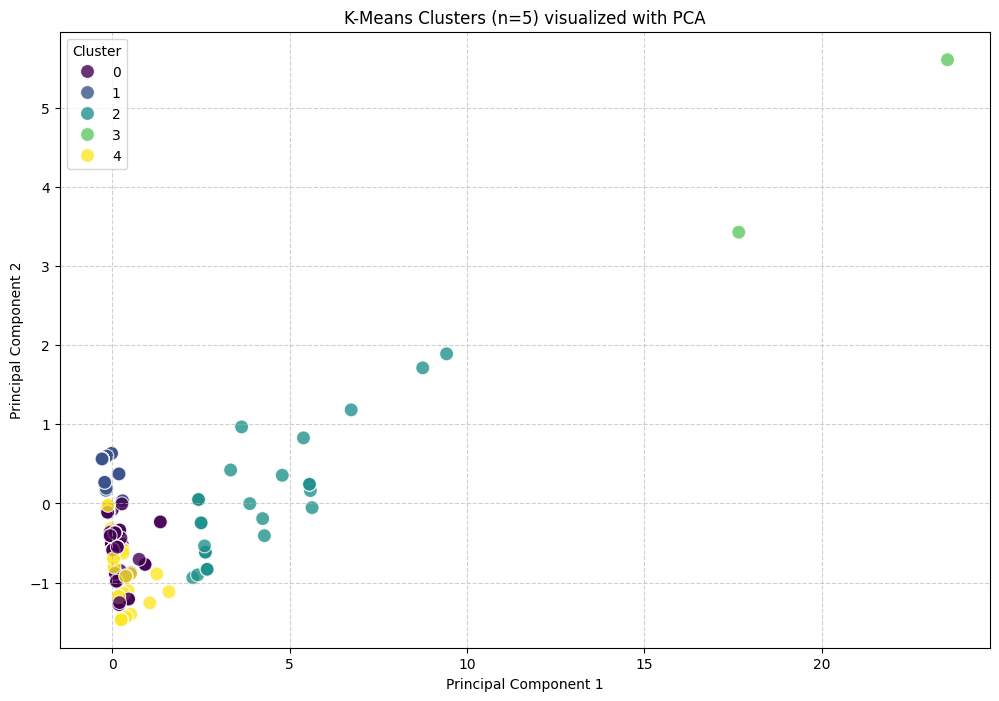

In [26]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Get the preprocessed data from the pipeline's preprocessor step
X_scaled = kmeans_pipeline.named_steps['preprocessor'].fit_transform(filtered_df[features])

# Apply PCA to reduce dimensions to 2 for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Create a DataFrame for PCA results and add cluster labels
pca_df = pd.DataFrame(data=X_pca, columns=['Principal Component 1', 'Principal Component 2'])
pca_df['Cluster'] = filtered_df['Cluster']

# Plot the clusters
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x='Principal Component 1',
    y='Principal Component 2',
    hue='Cluster',
    palette='viridis',
    data=pca_df,
    s=100, # Size of markers
    alpha=0.8
)
plt.title(f'K-Means Clusters (n={n_clusters}) visualized with PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

### Applying Anomaly Detection to 'Years of Experience' (YOE)

I will use the **Isolation Forest** algorithm to identify anomalies in the 'YOE' column. Isolation Forest is an effective unsupervised learning algorithm for anomaly detection. It works by isolating observations instead of profiling normal observations. It's particularly useful for high-dimensional datasets and can identify outliers with minimal assumptions about the data distribution.

In [24]:
from sklearn.ensemble import IsolationForest
import numpy as np

# Prepare the 'YOE' data for Isolation Forest
# Reshape the data to be 2D, as required by scikit-learn models
yoe_data = filtered_df['YOE'].values.reshape(-1, 1)

# Initialize the Isolation Forest model
# contamination is the proportion of outliers in the data set.
# A value of 'auto' will determine it based on the data, or you can specify a float (e.g., 0.01 for 1% outliers).
# For this demonstration, I'll start with a contamination of 0.01 (1%) as a reasonable estimate.
isolation_forest = IsolationForest(contamination=0.01, random_state=42)

# Fit the model and predict anomalies
# -1 indicates an outlier, 1 indicates an inlier
filtered_df['Anomaly'] = isolation_forest.fit_predict(yoe_data)

print("Value counts for the 'Anomaly' column:")
print(filtered_df['Anomaly'].value_counts())

Value counts for the 'Anomaly' column:
Anomaly
 1    1566
-1      16
Name: count, dtype: int64


### Visualizing Years of Experience Anomalies

To visualize the detected anomalies, I'll create a scatter plot of 'YOE' values. Anomalous data points (where 'Anomaly' is -1) will be highlighted in a different color to make them stand out. This will provide a clear visual representation of where the outliers are located within the distribution of years of experience.

### Characteristics of Detected Anomalies

Below are the rows from the `filtered_df` that were identified as anomalies (outliers) based on the 'Years of Experience' (YOE) column. Examining these rows can provide insights into why they were flagged as unusual.

In [23]:
# Filter the DataFrame to show only the anomalous data points
anomalies_df = filtered_df[filtered_df['Anomaly'] == -1]

# Display the characteristics of these anomalous entries
print("Anomalous Job Postings based on YOE:")
display(anomalies_df.head(20)) # Displaying up to 20 anomalous entries

Anomalous Job Postings based on YOE:


,Company,Role,Location,Application,YOE,Diploma,Job_type,Require_Sponsorship,Skill_Sets,Anomaly
57,Lennox International,Product Management Intern - Summer 2026,"Columbia, SC",https://uscareers-lennox.icims.com/jobs/50573/...,130.0,High School,Intern,False,"[C#/.NET, Cloud Platforms (AWS/Azure/GCP), Com...",-1
194,Uare.ai,Software Engineer – Early Career,"Mountain View, CA",https://job-boards.greenhouse.io/uareai/jobs/4...,28.0,High School,Full-Time,True,"[API/Architecture, C#/.NET, C/C++, Cloud Platf...",-1
285,McDonald's,Software Engineer I C#,"Chicago, IL",https://jobs.mcdonalds.com/job/Chicago-Softwar...,70.0,None,Intern,False,"[API/Architecture, Automated Testing & QA, C#/...",-1
479,Waters Corporation,Intern Data Analytics,United States,https://uscareers-waters.icims.com/jobs/24820/...,65.0,None,Intern,False,"[Big Data & Processing, Business/Analysis, C#/...",-1
573,↳,Research Intern - Climate Modeling,"Seattle, WA",https://job-boards.greenhouse.io/thealleninsti...,30.0,High School,Intern,True,"[API/Architecture, Automated Testing & QA, C#/...",-1
603,Mercer Advisors,Data Intern - Technology,Remote in USA,https://job-boards.greenhouse.io/merceradvisor...,40.0,High School,Intern,True,"[API/Architecture, Business/Analysis, C#/.NET,...",-1
635,Robert Bosch Venture Capital,Service Engineer Intern,"Vernon Hills, IL",https://jobs.smartrecruiters.com/BoschGroup/74...,35.0,None,Intern,True,"[API/Architecture, Automated Testing & QA, Bus...",-1
893,Intuit,Summer 2026 AI Science Intern,"4 locationsNYCMountain View, CAAtlanta, GASan ...",https://jobs.intuit.com/job/mountain-view/summ...,40.0,High School,Intern,False,"[API/Architecture, Big Data & Processing, C#/....",-1
1142,Point72,Quantitative Portfolio Analyst,"New York, NY",https://job-boards.greenhouse.io/point72/jobs/...,30.0,PhD,Intern,True,"[API/Architecture, Business/Analysis, C#/.NET,...",-1
1153,TransMarket Group,Junior Quantitative Trader,"Chicago, IL",https://job-boards.greenhouse.io/transmarketgr...,40.0,PhD,Intern,True,"[API/Architecture, C#/.NET, C/C++, Cloud Platf...",-1


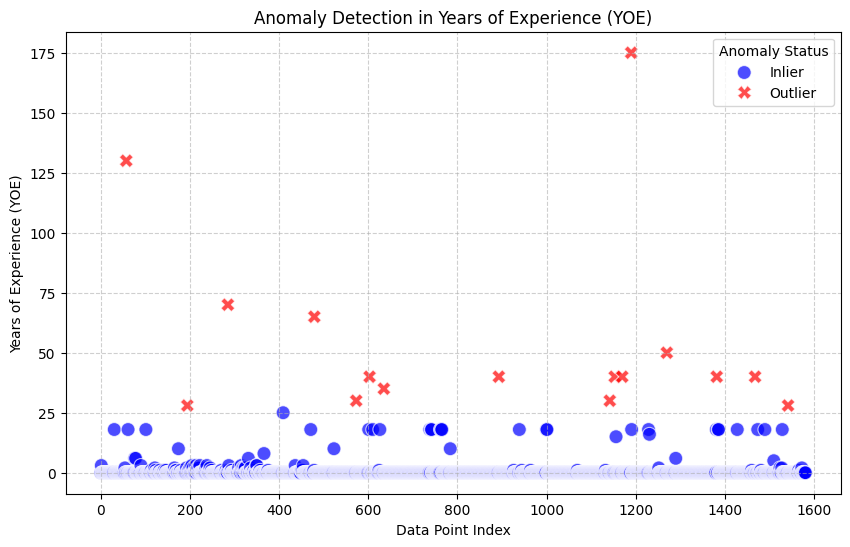

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a scatter plot to visualize YOE and highlight anomalies
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=filtered_df.index, # Using index for x-axis to spread points out
    y='YOE',
    hue='Anomaly', # Differentiate by anomaly status
    palette={1: 'blue', -1: 'red'}, # Blue for inliers, red for outliers
    style='Anomaly', # Different markers for inliers/outliers
    markers={1: 'o', -1: 'X'}, # Circle for inliers, 'X' for outliers
    data=filtered_df,
    s=100, # Size of markers
    alpha=0.7 # Transparency
)

plt.title('Anomaly Detection in Years of Experience (YOE)')
plt.xlabel('Data Point Index')
plt.ylabel('Years of Experience (YOE)')
plt.legend(title='Anomaly Status', labels=['Inlier', 'Outlier'])
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()